In [3]:
import tensorflow as tf
import os 
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
label_list = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
char_dict = dict(zip(label_list,range(10)))

In [ ]:
folders = glob.glob('./cifar10_image_data/*')
folders.sort()
num_classes = len(folders)
tfrecord_dir = './tfrecords/'
if not os.path.exists(tfrecord_dir):
    os.makedirs(tfrecord_dir)
writer = tf.python_io.TFRecordWriter('./tfrecords/train_data_shuffled1.tfrecord')
print(num_classes)

In [ ]:
# no shuffle to file 

for i,folder in enumerate(folders):
    label = folder.split('/')[-1]
    image_files = glob.glob(folder+'/*.jpg')
    for img_name in image_files:
        img = cv2.imread(img_name)
        height,width,channel = img.shape
#         img = cv2.resize(img,(32,32))
        img_raw = img.tobytes()
        label = i
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': tf.train.Feature(bytes_list = tf.train.BytesList(value=[img_raw])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
            'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
            'channel':tf.train.Feature(int64_list=tf.train.Int64List(value=[channel]))
        }))
        writer.write(example.SerializeToString())
#     print(label)
writer.close()


In [ ]:
# decode tfrecords
tf_test_file = './tfrecords/train_data_shuffled1.tfrecord'
tf_record_filename_queue = tf.train.string_input_producer([tf_test_file])
reader = tf.TFRecordReader()
_,example = reader.read(tf_record_filename_queue)
features = tf.parse_single_example(example,features={
    'image_raw':tf.FixedLenFeature([],tf.string),
    'label': tf.FixedLenFeature([],tf.int64),
    'height': tf.FixedLenFeature([],tf.int64),
    'width': tf.FixedLenFeature([],tf.int64),
    'channel': tf.FixedLenFeature([],tf.int64),
})
image = tf.decode_raw(features['image_raw'],tf.uint8)
label = tf.cast(features['label'],tf.int32)
height = tf.cast(features['height'],tf.int32)
width = tf.cast(features['width'],tf.int32)
channel = tf.cast(features['channel'],tf.int32)
image = tf.reshape(image,[height,width,channel])


In [ ]:
# test_tfrecord with different shape
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

In [ ]:
for i in range(200):
    img_loaded,label_loaded = sess.run([image,label])
plt.imshow(img_loaded[:,:,::-1])
print(img_loaded.shape)
print(label_loaded)
sess.close()

### tensorflow dataset api
因为上面的方法是使用tensorflow 比较旧，而且比较难用的队列管理输入数据，下面我们使用dataset api, 可以比较清晰地去实现输入的高效管理。
我们实践发现，现在文件层面使用shuffle可能会比较地快捷。所以下面使用了zip去实现。

In [ ]:
import random
test_files = glob.glob('./cifar10_image_data_test/*/*.jpg')
test_files.sort()
labels = [char_dict[file.split('/')[-2]] for file in test_files]
test_data = zip(test_files,labels)
test_data = list(test_data)
random.shuffle(test_data)

In [ ]:

writer = tf.python_io.TFRecordWriter('./tfrecords/test_data_shuffled.tfrecord')


# shuffled  test data in file stage
for image_path,label in test_data:
        img = cv2.imread(image_path)
        height,width,channel = img.shape
#         img = cv2.resize(img,(32,32))
        img_raw = img.tobytes()
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': tf.train.Feature(bytes_list = tf.train.BytesList(value=[img_raw])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
            'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
            'channel':tf.train.Feature(int64_list=tf.train.Int64List(value=[channel]))
        }))
        writer.write(example.SerializeToString())
#     print(label)
writer.close()

In [1]:
# use dataset api
def parser(record):
    features = tf.parse_single_example(record,features={
    'image_raw':tf.FixedLenFeature([],tf.string),
    'label': tf.FixedLenFeature([],tf.int64),
    'height': tf.FixedLenFeature([],tf.int64),
    'width': tf.FixedLenFeature([],tf.int64),
    'channel': tf.FixedLenFeature([],tf.int64),
    })
    
    image = tf.decode_raw(features['image_raw'],tf.uint8)
    label = tf.cast(features['label'],tf.int32)
    height = tf.cast(features['height'],tf.int32)
    width = tf.cast(features['width'],tf.int32)
    channel = tf.cast(features['channel'],tf.int32)
    image = tf.reshape(image,[height,width,channel])
    image = tf.image.resize_images(image,[32,32],method=0)
    return image,label

In [5]:
batch_size = 120
num_epochs = 100
train_file_name = './tfrecords/train_data_shuffled1.tfrecord'
train_file = tf.train.match_filenames_once(train_file_name)
dataset = tf.data.TFRecordDataset(train_file)
dataset = dataset.map(parser,num_parallel_calls=4)
dataset = dataset.shuffle(1000).batch(batch_size).repeat()     #这里还是会有问题的，如果不是接近整个dataset大小感觉不行
dataset = dataset.prefetch(10000)
iterator = dataset.make_initializable_iterator()
image_batch,label_batch = iterator.get_next()


In [6]:
# with tf.Session() as sess:
import time

sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(),
               tf.local_variables_initializer())
sess.run(init_op)
sess.run(iterator.initializer)


takes 0.019625
1


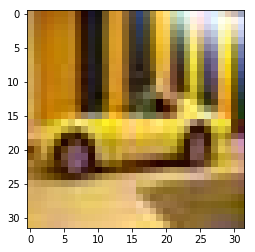

In [25]:
start = time.time()
for i in range(30):
    image_loaded,label_loaded = sess.run([image_batch,label_batch])
end = time.time()
print('takes %04f' %(end-start))
image_example = image_loaded[0].astype(np.uint8)
print(label_loaded[0])
plt.imshow(image_example[:,:,::-1])